In [ ]:
!nvidia-smi

Tue Sep 24 19:33:19 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   76C    P0              35W /  70W |   1161MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip /content/drive/MyDrive/data/archive_copy.zip

In [4]:
import os
import cv2
import tensorflow as tf
import pandas as pd
import numpy as np

In [7]:
df = pd.read_csv('/content/archive copy/sports.csv')
df.head()

class id                 filepaths      labels data set
0         0  train/air hockey/001.jpg  air hockey    train
1         0  train/air hockey/002.jpg  air hockey    train
2         0  train/air hockey/003.jpg  air hockey    train
3         0  train/air hockey/004.jpg  air hockey    train
4         0  train/air hockey/005.jpg  air hockey    train

In [8]:
#Data Augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import os



    # ImageDataGenerator for loading images
    datagen = None
    if set_no == 0:  # trining set
        datagen = ImageDataGenerator(
            rescale=1./255,              # Rescale pixel values from [0, 255] to [0, 1]
            rotation_range=10,           # Random rotations up to 10 degrees
            width_shift_range=0.1,       # Random horizontal shifts by 10%
            height_shift_range=0.1,      # Random vertical shifts by 10%
            shear_range=0.05,            # Shearing transformation
            zoom_range=0.075,            # Random zooms
            horizontal_flip=True,        # Random horizontal flips
            fill_mode='nearest'          # Fill mode for points outside boundaries
        )
    else:
        datagen = ImageDataGenerator(rescale=1.0/255.0)

    # Load images from the combined train and validation set
    data_gen = datagen.flow_from_dataframe(
        dataframe=dataframe,
        directory='/content/archive copy',
        x_col='filepaths',
        y_col='labels',
        target_size=(224, 224),
        batch_size=64,
        class_mode='categorical'
    )


    print("\n\n\n")
    return (dataframe, data_gen)

In [8]:
train_dir = '/content/archive copy/train'
test_dir = '/content/archive copy/test'
valid_dir = '/content/archive copy/valid'

# image generator to load in tf

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

# Validation data generator
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

# Test data generator
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

Found 13492 images belonging to 100 classes.
Found 500 images belonging to 100 classes.
Found 500 images belonging to 100 classes.


In [10]:
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.applications.xception import Xception

# Create Xception base model
input_shape = (224, 224, 3)
base_model_xception = Xception(weights='imagenet', include_top=False, input_shape= input_shape)

for layer in base_model_xception.layers:
    layer.trainable = False
# Create a Sequential model
model_xception = models.Sequential()

# Adding the Xception base model
model_xception.add(base_model_xception)

# Adding Global Average Pooling 2D layer
model_xception.add(layers.GlobalAveragePooling2D())

# Adding a Dense layer with 1024 units and 'relu' activation
# model_xception.add(Dense(1024, activation='relu'))

# Adding Dropout layer with a dropout rate of 0.5
model_xception.add(layers.Dropout(0.25))

# Adding another Dense layer with 512 units and 'relu' activation
# model_xception.add(Dense(512, activation='relu'))

# Adding Dropout layer with a dropout rate of 0.3
# model_xception.add(Dropout(0.3))

# Adding the final Dense layer with 100 units and 'softmax' activation
model_xception.add(layers.Dense(100, activation='softmax'))

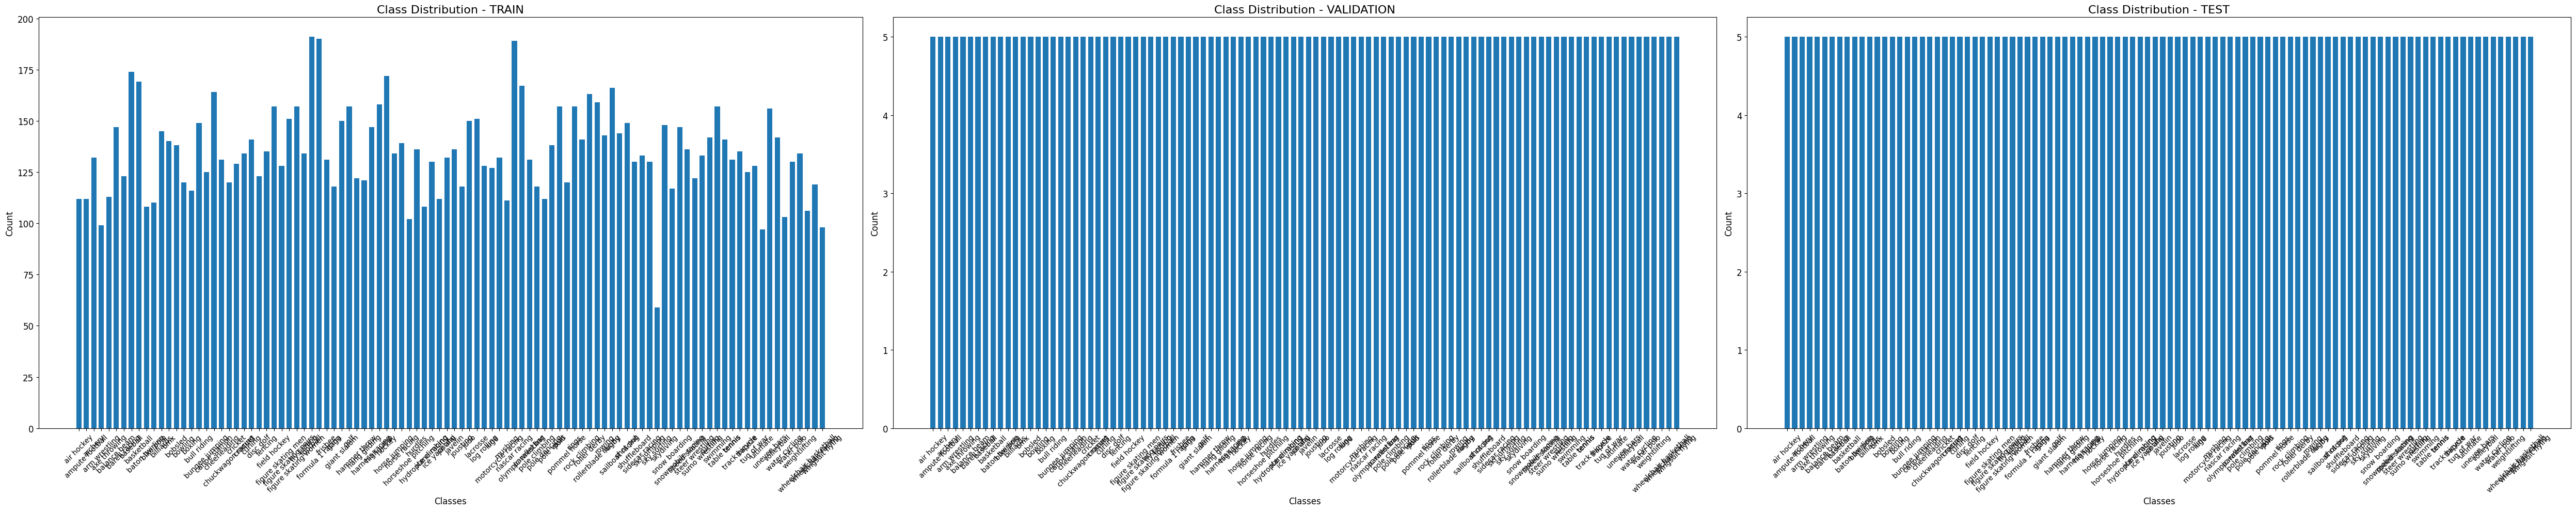

In [14]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Function to plot bar charts for class distribution
def plot_class_distribution_bar(train_generator, val_generator, test_generator):
    plt.figure(figsize=(50, 10))

    # Get the class labels from the generators
    class_labels = list(train_generator.class_indices.keys())

    # Train set
    plt.subplot(1, 3, 1)
    train_class_counts = pd.Series(train_generator.classes).value_counts().sort_index()
    plt.bar(np.arange(len(class_labels)), train_class_counts.values, tick_label=class_labels, width=0.7)
    plt.xticks(rotation=45, fontsize=10)
    plt.yticks(fontsize=12)
    plt.title("Class Distribution - TRAIN", fontsize=16)
    plt.xlabel("Classes", fontsize=12)
    plt.ylabel("Count", fontsize=12)

    # Validation set
    plt.subplot(1, 3, 2)
    val_class_counts = pd.Series(val_generator.classes).value_counts().sort_index()
    plt.bar(np.arange(len(class_labels)), val_class_counts.values, tick_label=class_labels, width=0.7)
    plt.xticks(rotation=45, fontsize=10)
    plt.yticks(fontsize=12)
    plt.title("Class Distribution - VALIDATION", fontsize=16)
    plt.xlabel("Classes", fontsize=12)
    plt.ylabel("Count", fontsize=12)

    # Test set
    plt.subplot(1, 3, 3)
    test_class_counts = pd.Series(test_generator.classes).value_counts().sort_index()
    plt.bar(np.arange(len(class_labels)), test_class_counts.values, tick_label=class_labels, width=0.7)
    plt.xticks(rotation=45, fontsize=10)
    plt.yticks(fontsize=12)
    plt.title("Class Distribution - TEST", fontsize=16)
    plt.xlabel("Classes", fontsize=12)
    plt.ylabel("Count", fontsize=12)

    plt.tight_layout()
    plt.show()

# Function call
plot_class_distribution_bar(train_generator, valid_generator, test_generator)


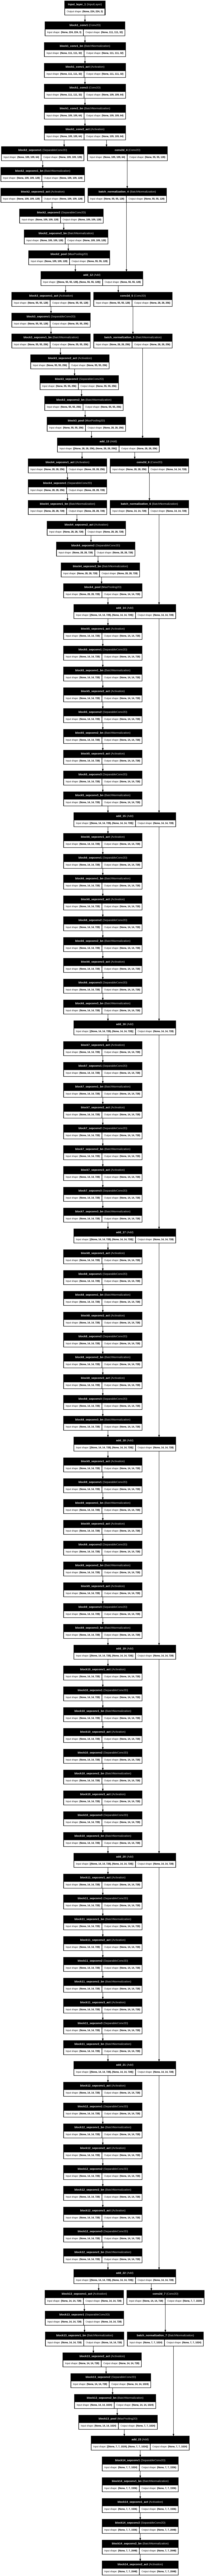

In [13]:
#!pip install pydot
#!pip install graphviz
#base model graph of xception
from tensorflow.keras.utils import plot_model

# Plot and save the model as an image file
plot_model(base_model_xception, to_file='model_xception.png', show_shapes=True, show_layer_names=True, dpi=96)


In [12]:
base_model_xception.summary()

Model: "xception"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 111, 111, 32)   │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_bn           │ (None, 111, 111, 32)   │            128 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_act          │ (None, 111, 111, 32)   │              0 │ block1_conv1_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 109, 109, 64)   │         18,432 │ block1_conv1_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_bn           │ (None, 109, 109, 64)   │            256 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_act          │ (None, 109, 109, 64)   │              0 │ block1_conv2_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1           │ (None, 109, 109, 128)  │          8,768 │ block1_conv2_act[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1_bn        │ (None, 109, 109, 128)  │            512 │ block2_sepconv1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_act       │ (None, 109, 109, 128)  │              0 │ block2_sepconv1_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2           │ (None, 109, 109, 128)  │         17,536 │ block2_sepconv2_act[0… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_bn        │ (None, 109, 109, 128)  │            512 │ block2_sepconv2[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 55, 55, 128)    │          8,192 │ block1_conv2_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 55, 55, 128)    │              0 │ block2_sepconv2_bn[0]… │
│ (MaxPooling2D)            │                        │                │                        │
├──────────────────────

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,861,480 (79.58 MB)

In [14]:
# Define optimizer with specific parameters
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-7)

model_xception.compile(optimizer='adam',loss='categorical_crossentropy'
                 ,metrics=['accuracy','Precision','Recall'])

In [ ]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history2=model_xception.fit(
        train_generator,
        epochs=20,
        validation_data=valid_generator,
        callbacks=[early_stopping, reduce_lr])

Epoch 1/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 352s 1s/step - Precision: 0.8315 - Recall: 0.3810 - accuracy: 0.5467 - loss: 1.9570 - val_Precision: 0.7682 - val_Recall: 0.6760 - val_accuracy: 0.7120 - val_loss: 1.0929 - learning_rate: 0.0010
Epoch 2/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 262s 988ms/step - Precision: 0.9464 - Recall: 0.8887 - accuracy: 0.9173 - loss: 0.2795 - val_Precision: 0.8447 - val_Recall: 0.7180 - val_accuracy: 0.7720 - val_loss: 0.7871 - learning_rate: 0.0010
Epoch 3/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 210s 988ms/step - Precision: 0.9656 - Recall: 0.9340 - accuracy: 0.9504 - loss: 0.1713 - val_Precision: 0.8412 - val_Recall: 0.7100 - val_accuracy: 0.7620 - val_loss: 0.8412 - learning_rate: 0.0010
Epoch 4/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 209s 987ms/step - Precision: 0.9681 - Recall: 0.9468 - accuracy: 0.9577 - loss: 0.1390 - val_Precision: 0.8872 - val_Recall: 0.8180 - val_accuracy: 0.8560 - val_loss: 0.5278 - learning_rate: 0.0010
Epoch 5/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 210s 989ms/

In [15]:
probabilities = model_xception.predict(test_generator)

# Print the probabilities for each image
print(probabilities)

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 132s 16s/step
[[0.01260355 0.00864721 0.00669275 ... 0.00959175 0.00866077 0.01121298]
 [0.00642109 0.00831076 0.00523311 ... 0.0040834  0.00401792 0.0130676 ]
 [0.00972067 0.0071232  0.00435577 ... 0.00546306 0.00871662 0.01660202]
 ...
 [0.01169497 0.0158292  0.00530293 ... 0.01637501 0.008435   0.00985603]
 [0.01067258 0.0071513  0.00501839 ... 0.01530412 0.00756587 0.00906572]
 [0.00580277 0.0135356  0.00556272 ... 0.01069322 0.00497533 0.0235156 ]]


In [20]:
probabilities = model_xception.predict(test_generator)

true_classes = test_generator.classes

class_labels = list(test_generator.class_indices.keys())

df = pd.DataFrame(probabilities, columns=class_labels)
df['True_Label'] = [class_labels[i] for i in true_classes]

print(df.head(30))

df.to_csv("test_predictions_with_labels.csv", index=False)


8/8 ━━━━━━━━━━━━━━━━━━━━ 128s 16s/step
    air hockey  ampute football   archery  arm wrestling  axe throwing  \
0     0.012604         0.008647  0.006693       0.016852      0.006011   
1     0.004604         0.007581  0.005031       0.017245      0.005709   
2     0.010944         0.011940  0.009752       0.009728      0.004617   
3     0.009352         0.006081  0.008333       0.017955      0.009456   
4     0.009322         0.007058  0.004194       0.009203      0.007127   
5     0.013635         0.008076  0.008492       0.023252      0.004292   
6     0.013884         0.011970  0.006827       0.016050      0.005731   
7     0.015329         0.008110  0.003425       0.008076      0.004920   
8     0.004512         0.003933  0.002885       0.018178      0.009681   
9     0.005661         0.008250  0.005051       0.013587      0.005793   
10    0.007940         0.004579  0.007304       0.016856      0.007283   
11    0.005207         0.005513  0.010913       0.009125      0.004576   

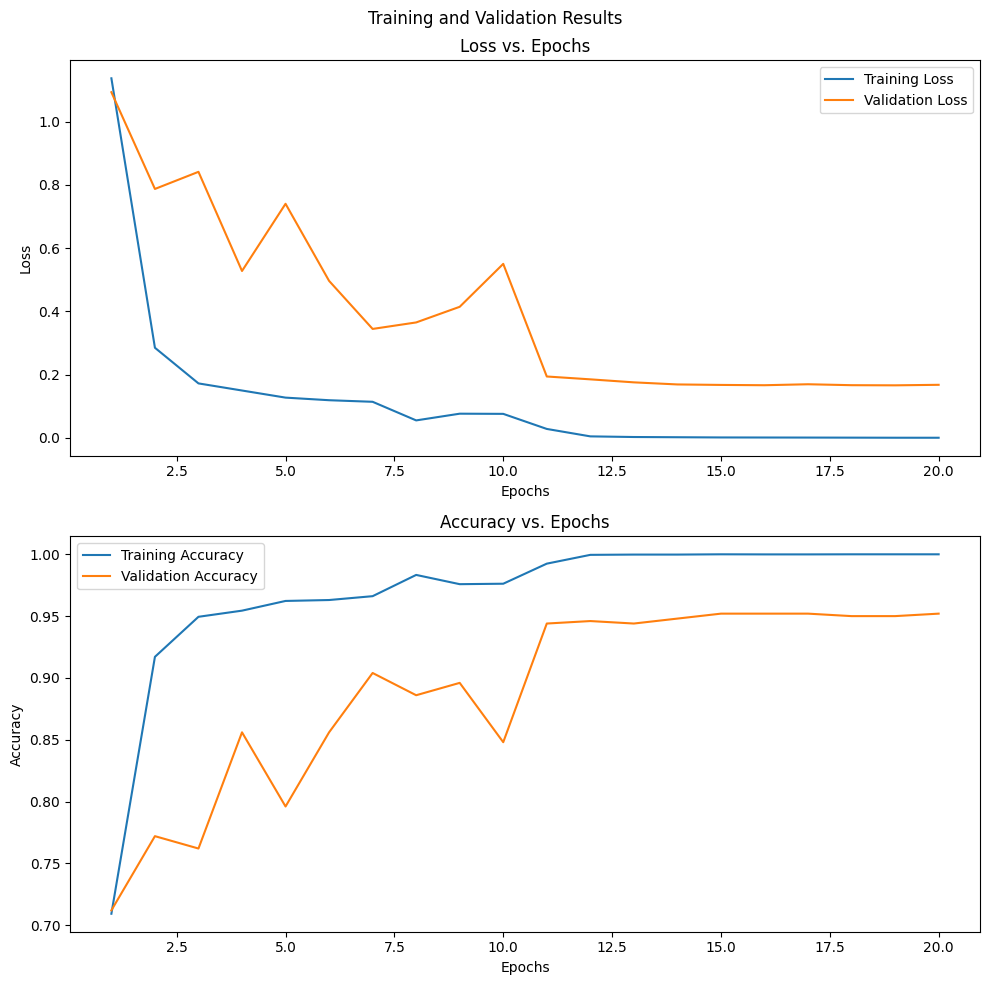

In [ ]:
import matplotlib.pyplot as plt

def plot_results(history2, title):
    epochs = range(1, len(history2.history['accuracy']) + 1)


    fig, axs = plt.subplots(2, 1, figsize=(10, 10))

    axs[0].plot(epochs, history2.history['loss'], label='Training Loss')
    axs[0].plot(epochs, history2.history['val_loss'], label='Validation Loss')
    axs[0].set_title('Loss vs. Epochs')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()

    axs[1].plot(epochs, history2.history['accuracy'], label='Training Accuracy')
    axs[1].plot(epochs, history2.history['val_accuracy'], label='Validation Accuracy')
    axs[1].set_title('Accuracy vs. Epochs')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

#
plot_results(history2, 'Training and Validation Results')


In [ ]:
train_loss = history2.history['loss']
train_accuracy = history2.history['accuracy']
val_loss = history2.history['val_loss']
val_accuracy = history2.history['val_accuracy']

print(f"Final Training Loss: {train_loss[-1]}")
print(f"Final Training Accuracy: {train_accuracy[-1]}")
print(f"Final Validation Loss: {val_loss[-1]}")
print(f"Final Validation Accuracy: {val_accuracy[-1]}")

Final Training Loss: 0.0006319913663901389
Final Training Accuracy: 1.0
Final Validation Loss: 0.1679784059524536
Final Validation Accuracy: 0.9520000219345093


In [ ]:
# Evaluate the model on the test set
test_acc = model_xception.evaluate(test_generator)[1]
test_loss = model_xception.evaluate(test_generator)[0]
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 285ms/step - Precision: 0.9809 - Recall: 0.9719 - accuracy: 0.9737 - loss: 0.0757
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 275ms/step - Precision: 0.9836 - Recall: 0.9700 - accuracy: 0.9814 - loss: 0.0684
Test Loss: 0.07798594981431961
Test Accuracy: 0.9760000109672546


8/8 ━━━━━━━━━━━━━━━━━━━━ 129s 16s/step


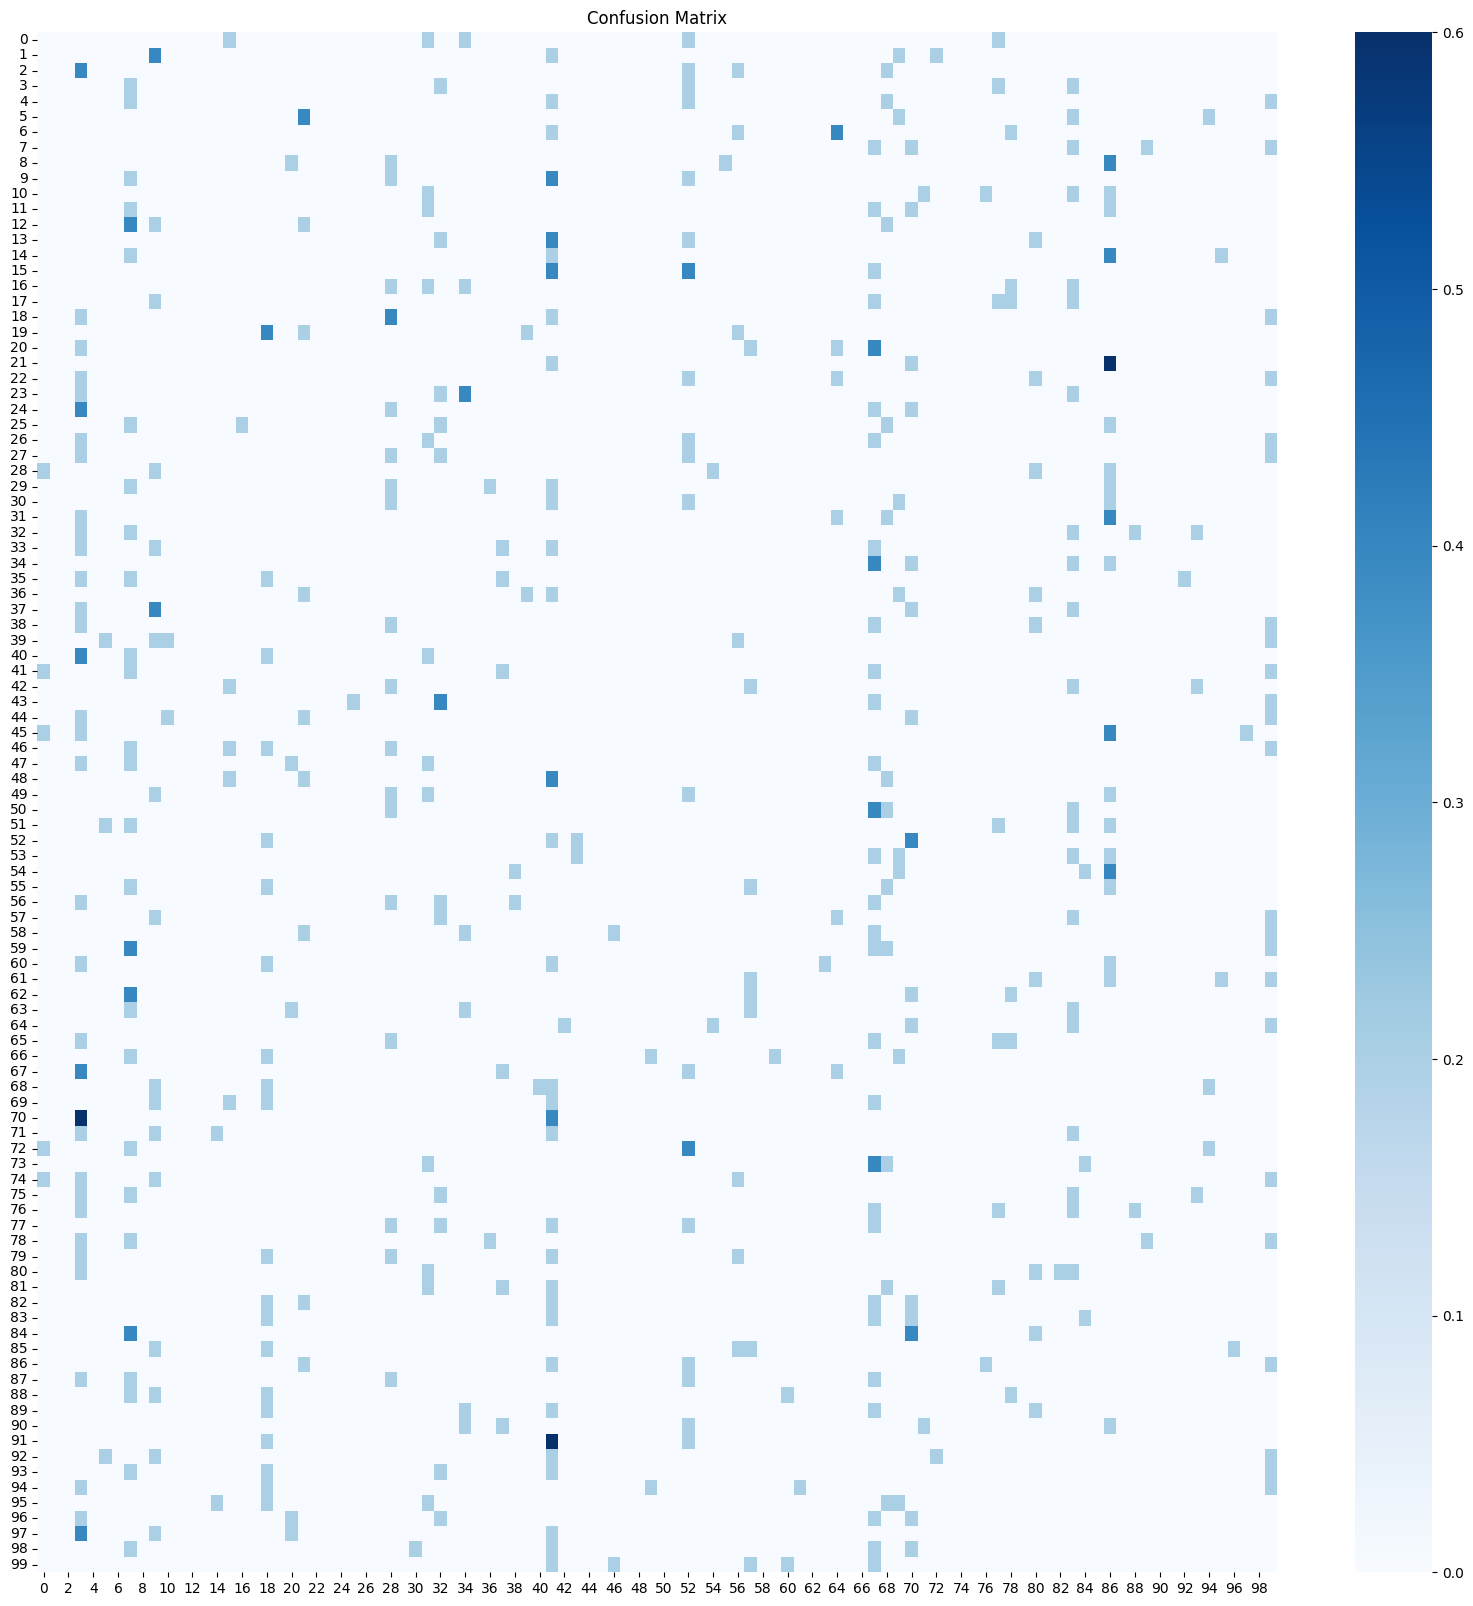

In [21]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict the labels for test data
y_pred = np.argmax(model_xception.predict(test_generator), axis=-1)
y_true = test_generator.classes

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(20, 20))
sns.heatmap(cm, annot=False, cmap="Blues", fmt=".2f")
plt.title("Confusion Matrix")
plt.show()




8/8 ━━━━━━━━━━━━━━━━━━━━ 141s 17s/step


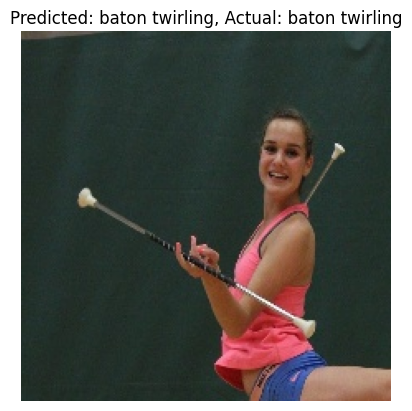

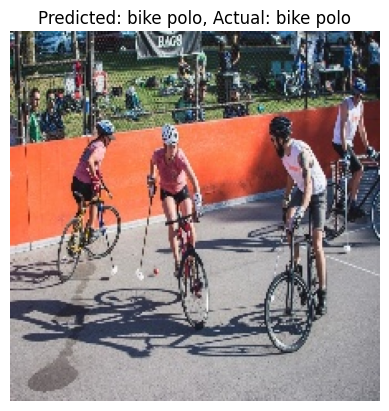

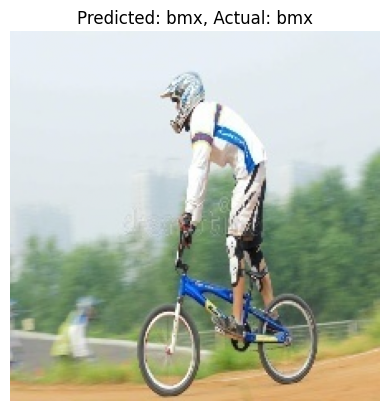

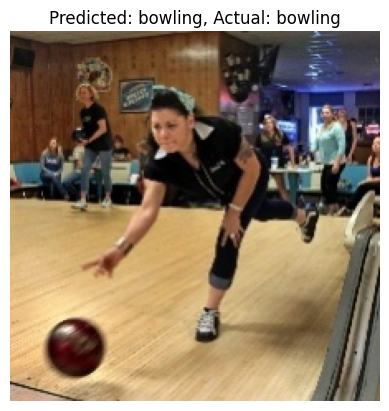

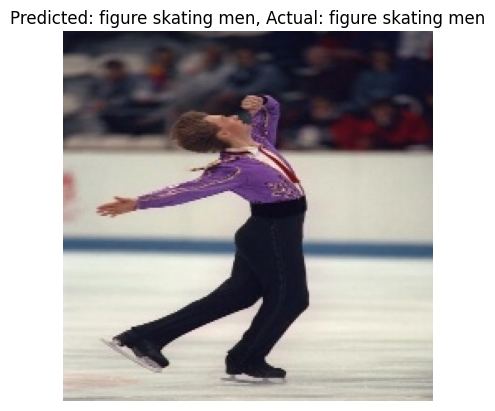

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import img_as_float, io

# Get true labels and predicted labels
y_true = test_generator.classes  # True labels from the generator
y_pred = model_xception.predict(test_generator)  # Predictions from the model
y_pred_classes = np.argmax(y_pred, axis=1)  # Get predicted class indices

# Class names (assuming test_generator has a class_indices attribute)
class_names = list(test_generator.class_indices.keys())

# Filepaths of test images from the generator
filepaths = test_generator.filepaths  # Get the filepaths from the generator

# Display correct predictions
correct_indices = np.where(y_pred_classes == y_true)[0]  # Indices where predictions match true labels
for i, idx in enumerate(correct_indices[:5]):  # Display the first 5 correct predictions
    img = img_as_float(io.imread(filepaths[idx]))  # Load the image
    plt.imshow(img)
    plt.title(f"Predicted: {class_names[y_pred_classes[idx]]}, Actual: {class_names[y_true[idx]]}")
    plt.axis('off')  # Hide axis for better visualization
    plt.show()


8/8 ━━━━━━━━━━━━━━━━━━━━ 136s 17s/step


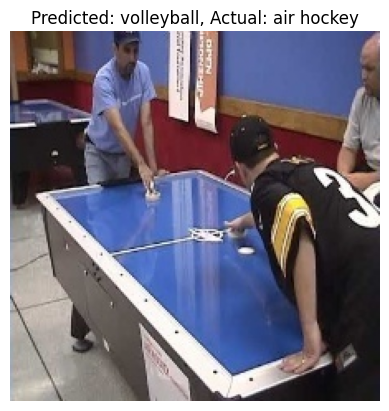

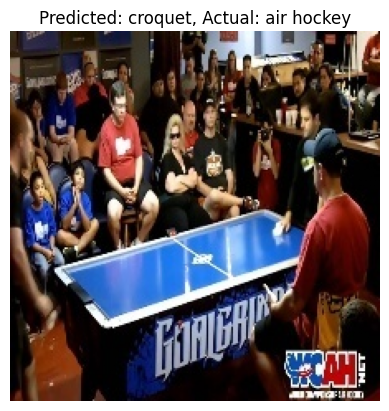

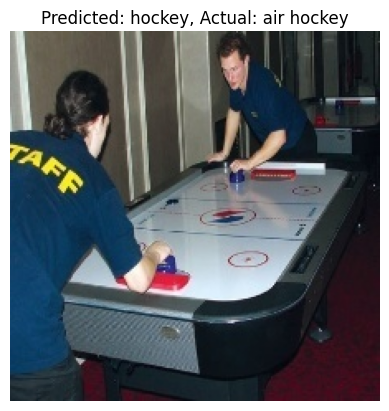

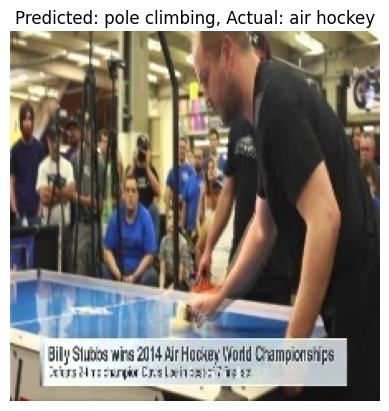

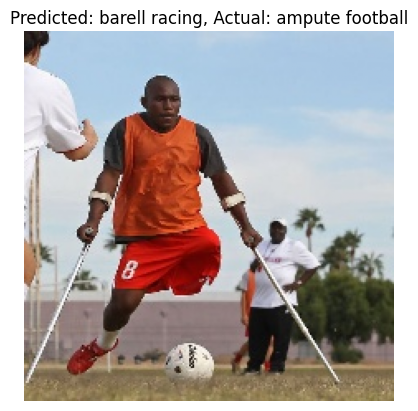

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import img_as_float, io

# Get true labels and predicted labels
y_true = test_generator.classes  # True labels from the generator
y_pred = model_xception.predict(test_generator)  # Predictions from the model
y_pred_classes = np.argmax(y_pred, axis=1)  # Get predicted class indices

# Class names (assuming test_generator has a class_indices attribute)
class_names = list(test_generator.class_indices.keys())

# Filepaths of test images from the generator
filepaths = test_generator.filepaths  # Get the filepaths from the generator

# Display incorrect predictions
incorrect_indices = np.where(y_pred_classes != y_true)[0]  # Indices where predictions do not match true labels
for i, idx in enumerate(incorrect_indices[:5]):  # Display the first 5 incorrect predictions
    img = img_as_float(io.imread(filepaths[idx]))  # Load the image
    plt.imshow(img)
    plt.title(f"Predicted: {class_names[y_pred_classes[idx]]}, Actual: {class_names[y_true[idx]]}")
    plt.axis('off')  # Hide axis for better visualization
    plt.show()


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Build the CNN model
model = Sequential()

# Block 1
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

# Block 2
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

# Block 3
model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

# Block 4
model.add(Conv2D(filters=512, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=512, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

# Global Average Pooling and fully connected layers
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(100, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Model summary
model.summary()

# Callbacks for learning rate reduction and early stopping
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-7)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 222, 222, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 222, 222, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 220, 220, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 220, 220, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 110, 110, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 110, 110, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 108, 108, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 108, 108, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 106, 106, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 106, 106, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 53, 53, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 53, 53, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 51, 51, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 51, 51, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 49, 49, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 49, 49, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 24, 24, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 24, 24, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 4,850,084 (18.50 MB)

 Trainable params: 4,846,244 (18.49 MB)

 Non-trainable params: 3,840 (15.00 KB)

In [ ]:
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=30,
    callbacks=[reduce_lr, early_stopping]
)


Epoch 1/100
211/211 ━━━━━━━━━━━━━━━━━━━━ 224s 782ms/step - accuracy: 0.0421 - loss: 4.6002 - val_accuracy: 0.0100 - val_loss: 5.8009 - learning_rate: 1.0000e-04
Epoch 2/100
211/211 ━━━━━━━━━━━━━━━━━━━━ 84s 395ms/step - accuracy: 0.1045 - loss: 3.9259 - val_accuracy: 0.0220 - val_loss: 5.2539 - learning_rate: 1.0000e-04
Epoch 3/100
211/211 ━━━━━━━━━━━━━━━━━━━━ 84s 395ms/step - accuracy: 0.1536 - loss: 3.6184 - val_accuracy: 0.0380 - val_loss: 4.8880 - learning_rate: 1.0000e-04
Epoch 4/100
211/211 ━━━━━━━━━━━━━━━━━━━━ 84s 395ms/step - accuracy: 0.1943 - loss: 3.3885 - val_accuracy: 0.0700 - val_loss: 4.1845 - learning_rate: 1.0000e-04
Epoch 5/100
211/211 ━━━━━━━━━━━━━━━━━━━━ 84s 395ms/step - accuracy: 0.2219 - loss: 3.1993 - val_accuracy: 0.0920 - val_loss: 3.9222 - learning_rate: 1.0000e-04
Epoch 6/100
211/211 ━━━━━━━━━━━━━━━━━━━━ 84s 395ms/step - accuracy: 0.2589 - loss: 3.0004 - val_accuracy: 0.1000 - val_loss: 4.0832 - learning_rate: 1.0000e-04
Epoch 7/100
211/211 ━━━━━━━━━━━━━━━━━━━

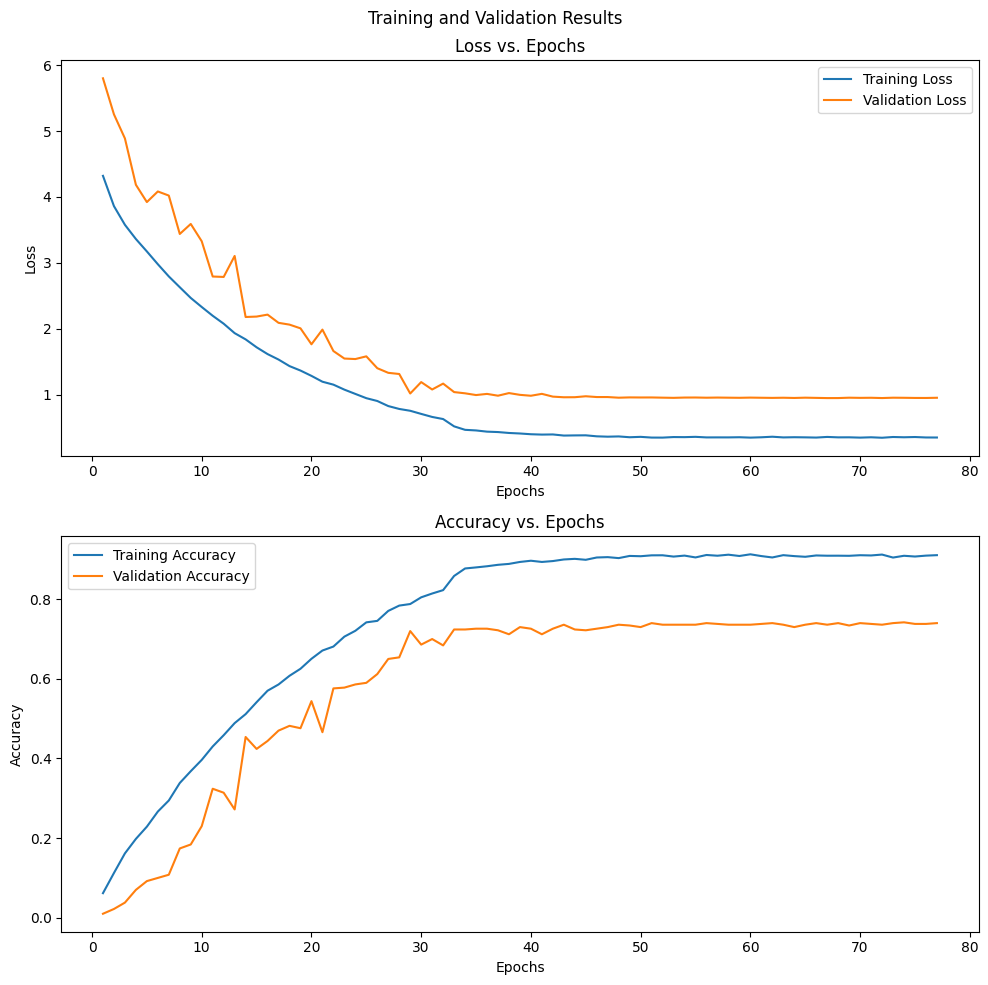

In [ ]:
import matplotlib.pyplot as plt

def plot_results(history, title):
    epochs = range(1, len(history.history['accuracy']) + 1)


    fig, axs = plt.subplots(2, 1, figsize=(10, 10))

    axs[0].plot(epochs, history.history['loss'], label='Training Loss')
    axs[0].plot(epochs, history.history['val_loss'], label='Validation Loss')
    axs[0].set_title('Loss vs. Epochs')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()

    axs[1].plot(epochs, history.history['accuracy'], label='Training Accuracy')
    axs[1].plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
    axs[1].set_title('Accuracy vs. Epochs')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

#
plot_results(history, 'Training and Validation Results')


In [ ]:
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

print(f"Final Training Loss: {train_loss[-1]}")
print(f"Final Training Accuracy: {train_accuracy[-1]}")
print(f"Final Validation Loss: {val_loss[-1]}")
print(f"Final Validation Accuracy: {val_accuracy[-1]}")

Final Training Loss: 0.34832096099853516
Final Training Accuracy: 0.9106878042221069
Final Validation Loss: 0.9515893459320068
Final Validation Accuracy: 0.7400000095367432


In [ ]:
# Evaluate the model on the test set
test_acc = model.evaluate(test_generator)[1]
test_loss = model.evaluate(test_generator)[0]
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")


1/8 ━━━━━━━━━━━━━━━━━━━━ 1s 230ms/step - accuracy: 0.7500 - loss: 0.7800

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 0.7596 - loss: 0.8040
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 0.7586 - loss: 0.8351
Test Loss: 0.8152586817741394
Test Accuracy: 0.7639999985694885
